# Simulating excitatory-inhibitory spiking networks with ``brainpy``

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainpy_EI_spiking_network.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainpy_EI_spiking_network.ipynb)

Implementation of the EI network from Brunel (1996) with the brainstate package.

- Van Vreeswijk, Carl, and Haim Sompolinsky. “Chaos in neuronal networks with balanced excitatory and inhibitory activity.” Science 274.5293 (1996): 1724-1726.

This notebook demonstrates how to build and simulate a classic Excitatory–Inhibitory (E–I) spiking network using the BrainState backend. It walks through model assumptions, equations, parameters, connectivity, and analysis so you can adapt it to your own studies.

## Model overview

- Populations: one excitatory (E) and one inhibitory (I) population with leaky integrate-and-fire (LIF) neurons by default.
- Synapses: current-based or conductance-based synapses (model-dependent), with E→E, E→I, I→E, I→I projections configurable.
- External drive: constant background current and/or Poisson input can be enabled to elicit activity and oscillations.


## Network dynamics

Dynamic of membrane potential is given as:

$$ \tau \frac {dV_i}{dt} = -(V_i - V_{rest}) + I_i^{ext} + I_i^{net} (t) $$

where $I_i^{net}(t)$ represents the synaptic current, which describes the sum of excitatory and inhibitory neurons.

$$ I_i^{net} (t) = J_E \sum_{j=1}^{pN_e} \sum_{t_j^\alpha < t} f(t-t_j^\alpha ) - J_I \sum_{j=1}^{pN_i} \sum_{t_j^\alpha < t} f(t-t_j^\alpha )$$

where

$$
f(t) = \begin{cases} {\rm exp} (-\frac t {\tau_s} ), \quad t \geq 0 \\
0, \quad t < 0 \end{cases}
$$

Parameters: $J_E = \frac 1 {\sqrt {pN_e}}, J_I = \frac 1 {\sqrt {pN_i}}$

## Network

In [1]:
import brainunit as u
import brainstate
import brainpy

In [2]:
class EINet(brainstate.nn.Module):
    def __init__(self, n_exc, n_inh, prob, JE, JI):
        super().__init__()
        self.n_exc = n_exc
        self.n_inh = n_inh
        self.num = n_exc + n_inh

        # neurons
        self.N = brainpy.state.LIF(
            n_exc + n_inh,
            V_rest=-52. * u.mV, V_th=-50. * u.mV, V_reset=-60. * u.mV, tau=10. * u.ms,
            V_initializer=brainstate.init.Normal(-60., 10., unit=u.mV), spk_reset='soft'
        )

        # synapses
        self.E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, self.num, prob, JE),
            syn=brainpy.state.Expon.desc(self.num, tau=2. * u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.N,
        )
        self.I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, self.num, prob, JI),
            syn=brainpy.state.Expon.desc(self.num, tau=2. * u.ms),
            out=brainpy.state.CUBA.desc(),
            post=self.N,
        )

    def update(self, inp):
        spks = self.N.get_spike() != 0.
        self.E(spks[:self.n_exc])
        self.I(spks[self.n_exc:])
        self.N(inp)
        return self.N.get_spike()

## Simulation

In [3]:
# connectivity
num_exc = 500
num_inh = 500
prob = 0.1
# external current
Ib = 3. * u.mA
# excitatory and inhibitory synaptic weights
JE = 1 / u.math.sqrt(prob * num_exc) * u.mS
JI = -1 / u.math.sqrt(prob * num_inh) * u.mS

In [4]:
# network
brainstate.environ.set(dt=0.1 * u.ms)
net = EINet(num_exc, num_inh, prob=prob, JE=JE, JI=JI)
_ = brainstate.nn.init_all_states(net)

In [5]:
# simulation
times = u.math.arange(0. * u.ms, 1000. * u.ms, brainstate.environ.get_dt())
spikes = brainstate.compile.for_loop(lambda t: net.update(Ib), times, pbar=brainstate.compile.ProgressBar(10))


  0%|          | 0/10000 [00:00<?, ?it/s]

## Visualization

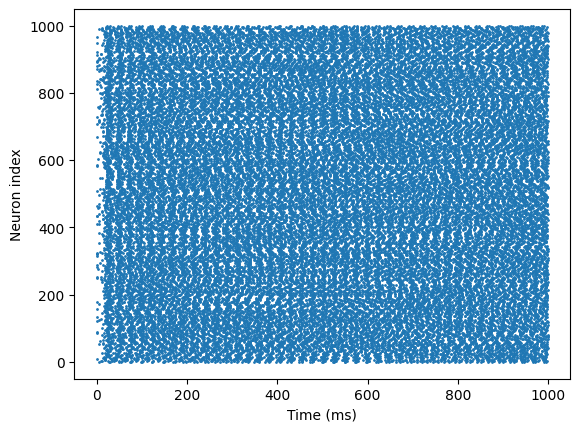

In [6]:
import matplotlib.pyplot as plt

# visualization
t_indices, n_indices = u.math.where(spikes)
plt.scatter(times[t_indices], n_indices, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

## Analysis checklist

- Plot spike raster for a subset of neurons from E and I.
- Compute population-averaged firing rates with a 5–10 ms bin; smooth with a Gaussian window (σ≈5 ms).
- Build an LFP proxy (e.g., mean V over E or total syn current to I) and compute its PSD (e.g., via Welch).
- Inspect gamma peak frequency and bandwidth; relate to synaptic τ and weights.
- Perform parameter sweeps over $J_\mathrm{EI}$ and $J_{IE}$ to map oscillatory regimes.